### Import Libraries

In [1]:
import os
import cv2
import numpy as np
import histomicstk as htk
import scipy as sp
import skimage.io
import skimage.measure
import skimage.color
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Reading in color default. Change to zero for grayscale
def read_image(filename,mode=1):
    try:
        img = cv2.imread(filename,mode)
    except e:
        raise e
    if img is None:
        print('Check your path. Not a file path. Probably a folder path.')
    return img

def write_image(filename,img):
    try:
        cv2.imwrite(filename,img)
    except e:
        raise e
        
def image_check(image_name):
    if image_name.split('.')[-1] not in ['jpg','jpeg','png']:
        return False
    return True
    

### Segmentation Process

Used some implementations from https://github.com/DigitalSlideArchive/HistomicsTK

In [3]:
intensity = 180 #segmentation intensity
multi_process = True #multi core process for nuclei segmentation

In [4]:
ref_path = r'BM_GRAZ_HE_0007_01.png'
ref_img = read_image(ref_path)

In [5]:
image_path = r"Input_Images/01_1.png"
gt_path = r"Ground_Truth/01_1.png"
# Sometimes we get 4 dimensions that's why specify upto 3 for RGB colorspace
imInput = skimage.io.imread(image_path)[:, :, :3]
imReference = skimage.io.imread(ref_path)[:, :, :3]
gt = skimage.io.imread(gt_path)[:,:,0]

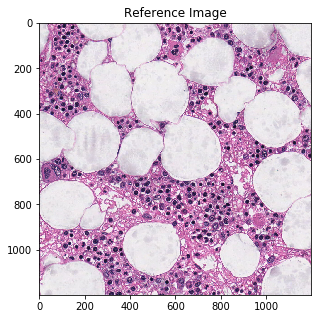

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(imReference)
plt.title('Reference Image')
plt.show()

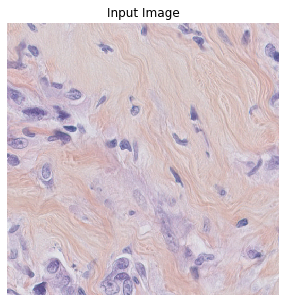

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(imInput)
plt.axis('off')
plt.title('Input Image')
plt.show()

In [8]:
# Get the mean and standard deviation of reference image in LAB colorspace

meanRef, stdRef = htk.preprocessing.color_conversion.lab_mean_std(imReference)

In [9]:
# Perform Reinhard Color Normalization on Input Image

imNmzd = htk.preprocessing.color_normalization.reinhard(imInput,meanRef,stdRef)

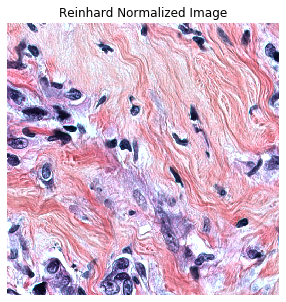

In [10]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imNmzd)
plt.title('Reinhard Normalized Image')
plt.show()

In [11]:
# Macenko PCA to get the stain vectors 
I_0 = 255
w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(imNmzd,I_0=255)

/home/satya/Vijay/histomics/HistomicsTK/histomicstk/preprocessing/color_conversion/rgb_to_sda.py:48: RuntimeWarning: divide by zero encountered in log
  im_sda = -np.log(im_rgb/(1.*I_0)) * 255/np.log(I_0)


In [12]:
# Get the stain color map for deconvolution
stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map

In [13]:
stain_color_map

{'hematoxylin': [0.65, 0.7, 0.29],
 'eosin': [0.07, 0.99, 0.11],
 'dab': [0.27, 0.57, 0.78],
 'null': [0.0, 0.0, 0.0]}

In [14]:
stains = ['hematoxylin','eosin','null']

In [15]:
# Perform the deconvolution using the stain vectors

deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(imInput, w_est,I_0)

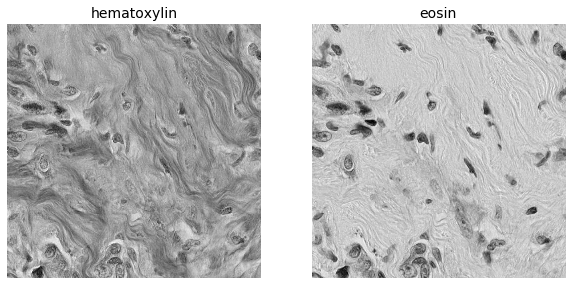

In [16]:
# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(deconv_result.Stains[:, :, 0])
plt.title(stain_1, fontsize=14)

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(deconv_result.Stains[:, :, 1])
_ = plt.title(stain_2, fontsize=14)

In [17]:
imNucleiStain = deconv_result.Stains[:,:,1]

In [18]:
imNucleiStain.shape

(512, 512)

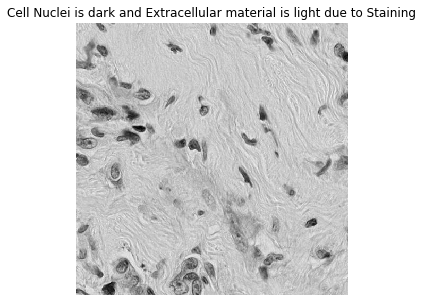

In [19]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imNucleiStain)
plt.title('Cell Nuclei is dark and Extracellular material is light due to Staining')
plt.show()

In [20]:
# Now we do segmentation based on a fixed intensity value. Here we chose it as 160

foreground_threshold = 160

imFgndMask = sp.ndimage.morphology.binary_fill_holes(imNucleiStain<foreground_threshold)

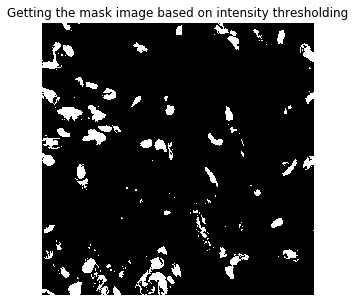

In [21]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imFgndMask)
plt.title('Getting the mask image based on intensity thresholding')
plt.show()

### Smoothening the image

In [22]:
min_radius = 10
max_radius = 60
imLog = htk.filters.shape.clog(imNucleiStain, imFgndMask,\
                               sigma_min=min_radius * np.sqrt(2),\
                               sigma_max=max_radius * np.sqrt(2))

In [23]:
# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10
imNucleiSegMask1, Seeds, Max = htk.segmentation.nuclear.max_clustering(
    imLog[0], imFgndMask, local_max_search_radius)

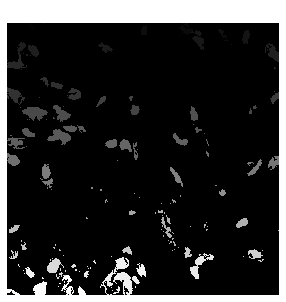

In [24]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imNucleiSegMask1)
plt.title(' ')
plt.show()

In [25]:
min_nucleus_area = 150
imNucleiSegMask = htk.segmentation.label.area_open(
    imNucleiSegMask1, min_nucleus_area).astype(np.int)

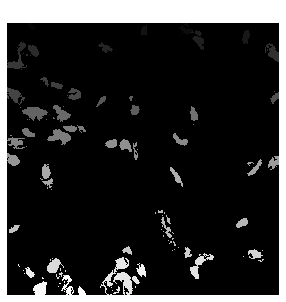

In [26]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imNucleiSegMask)
plt.title(' ')
plt.show()

In [27]:
imNucleicompact = htk.segmentation.label.compact(imNucleiSegMask, compaction=3)
k= (imNucleicompact==-1)
imNucleicompact1=np.copy(k)
plt.rcParams['figure.figsize'] = 15,15    
for ii in range(0,imNucleicompact.shape[0]):
    for jj in range(0,imNucleicompact.shape[1]):
        if imNucleicompact[ii,jj]>0:
            imNucleicompact1[ii,jj]=1

imNucleicompact2 = skimage.measure.label(imNucleicompact1,connectivity = 1)
imInput2 = np.copy(imNmzd)
plt.rcParams['figure.figsize'] = 1, 1

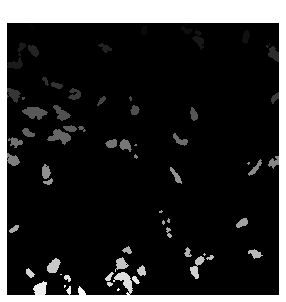

In [28]:
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(imNucleicompact2)
plt.title(' ')
plt.show()

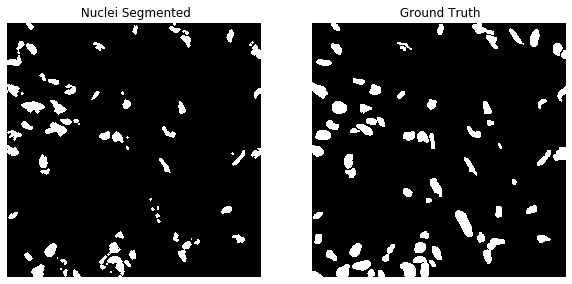

In [29]:
mask_generated = np.copy(imNucleicompact2)
mask_generated[mask_generated>0] = 1
gt[gt>0] = 1

# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(mask_generated)
plt.title(' Nuclei Segmented')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(gt)
plt.title(' Ground Truth')
plt.show()

Text(0.5, 1.0, ' Nuclei Segmented')

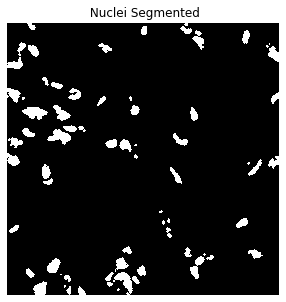

In [30]:
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(mask_generated)
plt.title(' Nuclei Segmented')

In [31]:
def iou(img1, img2):
    intersection = np.sum(img1*img2)
    union = np.sum(img1 + img2) - intersection
    
    return intersection/union

In [32]:
iou(gt, mask_generated)

0.5345275483695863

Number of nuclei = 75


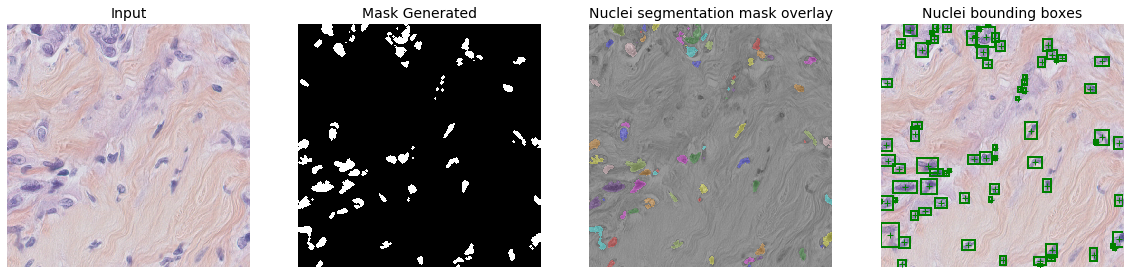

In [33]:
# compute nuclei properties
objProps = skimage.measure.regionprops(imNucleicompact2)

print('Number of nuclei = {}'.format(len(objProps)))

# Display results
plt.figure(figsize=(20, 10))
titlesize = 14

plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow( imInput)
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Input', fontsize=titlesize)

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow( mask_generated)
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Mask Generated', fontsize=titlesize)

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(skimage.color.label2rgb(imNucleicompact2, imInput, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow( imInput)
plt.xlim([0, imInput.shape[1]])
plt.ylim([0, imInput.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

for i in range(len(objProps)):

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] , 
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)
    
